# Time Series Analysis by LSTM (Long Short Term Memory)

In this project we will apply Recurrent Neural Network (LSTM) which is best suited for time-series and sequential problem. This approach is the best if we have large data. The data that we will be using for this project is taken from www.kaggle.com, The 'Household Electric Power Consumption' Dataset have the following features :

- date: Date in format dd/mm/yyyy

- time: time in format hh:mm:ss

- global_active_power: household global minute-averaged active power (in kilowatt)

- global_reactive_power: household global minute-averaged reactive power (in kilowatt)

- voltage: minute-averaged voltage (in volt)

- global_intensity: household global minute-averaged current intensity (in ampere)

- sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a   dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

- sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a     washing-machine, a tumble-drier, a refrigerator and a light.

- sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an     air-conditioner.

## Importing the important Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

In [2]:
# reading the dataset (household_power_consumption.txt)

data = pd.read_csv('household_power_consumption.txt', sep = ';', parse_dates={'dt' : ['Date', 'Time']}, 
                   infer_datetime_format=True, low_memory=False, na_values=['nan','?'], index_col='dt')

- the data include 'nan' and '?' as a string so they are converted to numpy 'nan'.
- merged two columns 'Date' and 'Time' to 'dt'.
- converted the data to time-series type, by taking index to be the time.

In [3]:
# visualizing the data

data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


We can see clearly that our datetime column (dt) is used as an index, we have 2075259 rows and 7 columns 

## Analyzing the data

In [4]:
# checking for the properties of data

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


All the 7 features have 'float64' datatype and there are no categorical features, so we dont need to perform any feature encoding.

In [5]:
# checking for the null values in the data

data.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

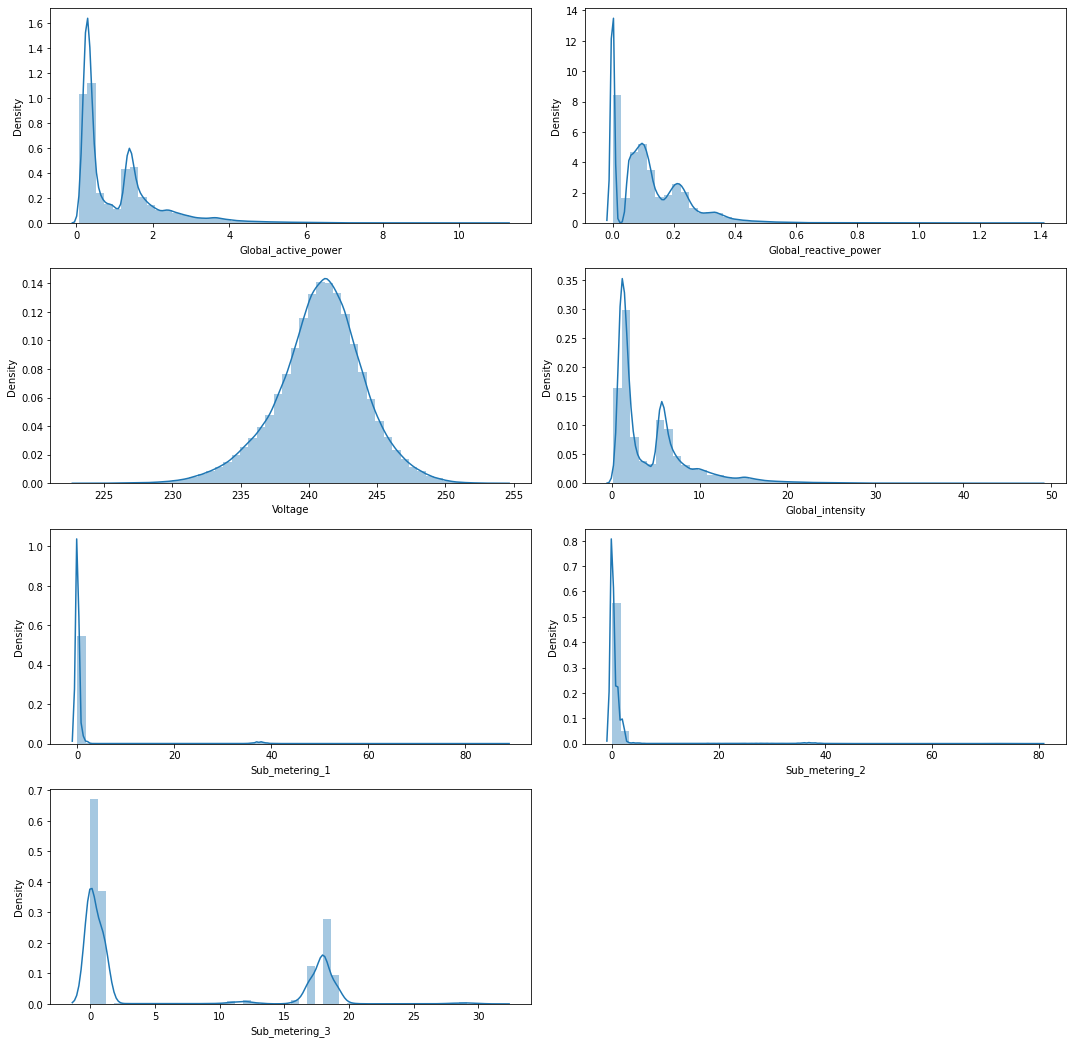

In [6]:
# observing the distribution of data for different features

plt.figure(figsize = (15,25))
i = 1
for features in data.columns:
    plt.subplot(len(data.columns),2,i)
    sns.distplot(data[features])
    plt.tight_layout()
    i += 1

From the above plots it can be clearly seen the data is nearlly normally distributed for 'Voltage' and for all other features it is right skewed highly so we can handle the 'Nan' values for 'voltage' with mean value and for other features it can be handled by using median.

In [7]:
# handling null values for 'Voltage'

data['Voltage'].fillna(data['Voltage'].mean(), inplace = True)

In [8]:
# handling null values for rest of the features

for features in data.columns:
    if (features != 'Voltage'):
        data[features].fillna(data[features].mean(), inplace = True)

In [9]:
# re-checking if the null values are handled 

data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## Visualizing the features for different intervals 

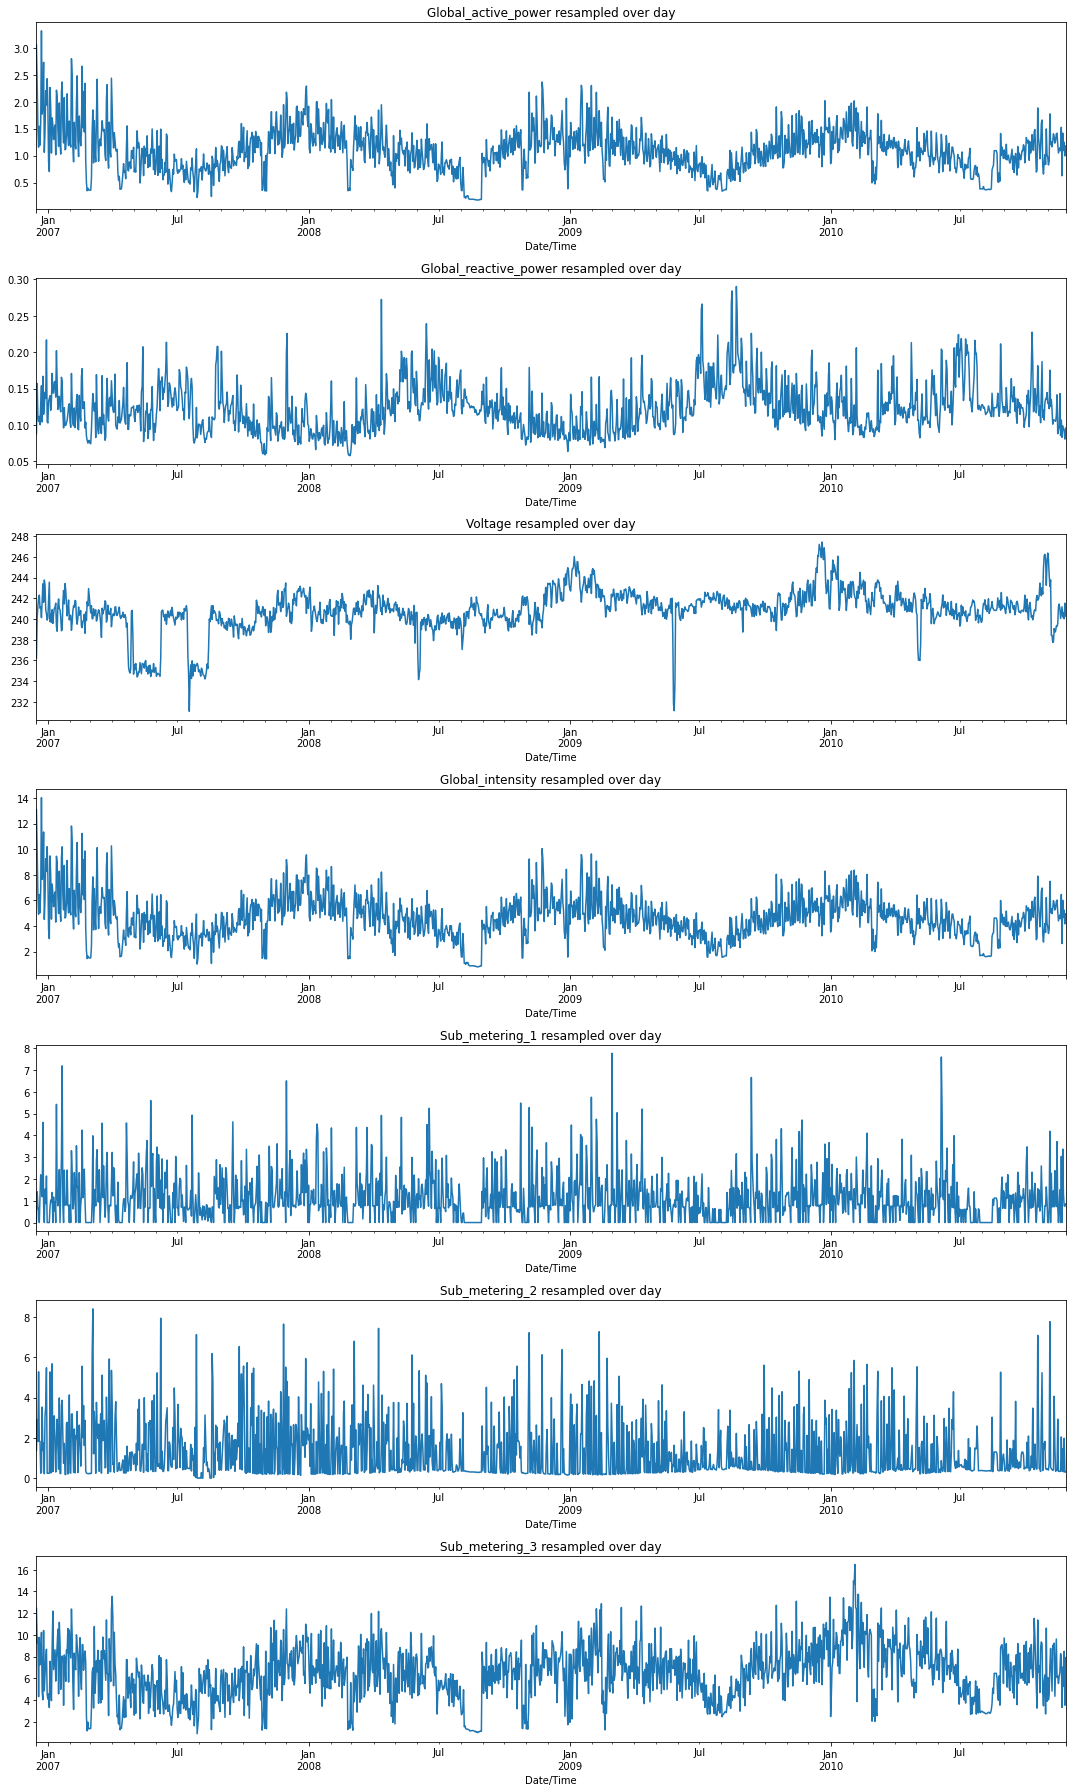

In [10]:
# Observing by resampling data for Day

i = 1
plt.figure(figsize = (15,25))
for feature in data.columns:
    plt.subplot(len(data.columns),1,i)
    data[feature].resample('D').mean().plot(title = '{} resampled over day'.format(feature))
    plt.xlabel('Date/Time')
    plt.tight_layout()
    i += 1

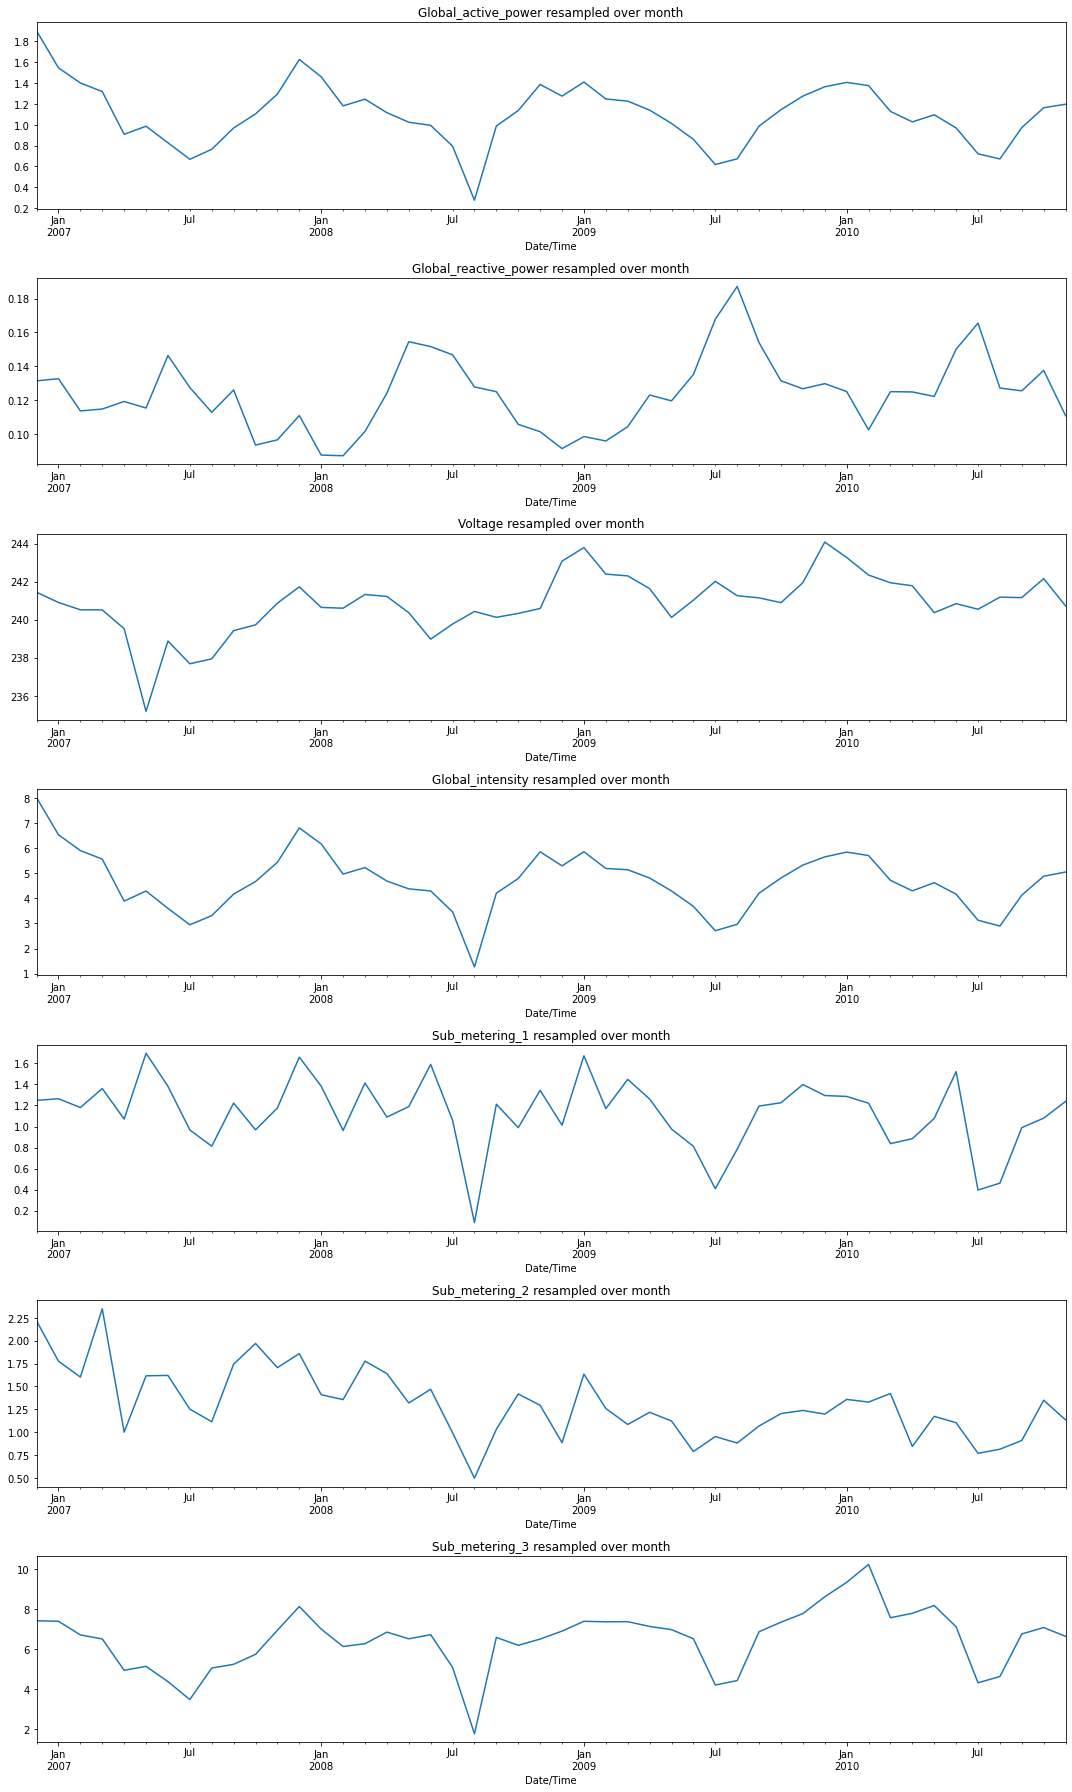

In [11]:
# Observing by resampling data for Month

i = 1
plt.figure(figsize = (15,25))
for feature in data.columns:
    plt.subplot(len(data.columns),1,i)
    data[feature].resample('M').mean().plot(title = '{} resampled over month'.format(feature))
    plt.xlabel('Date/Time')
    plt.tight_layout()
    i += 1

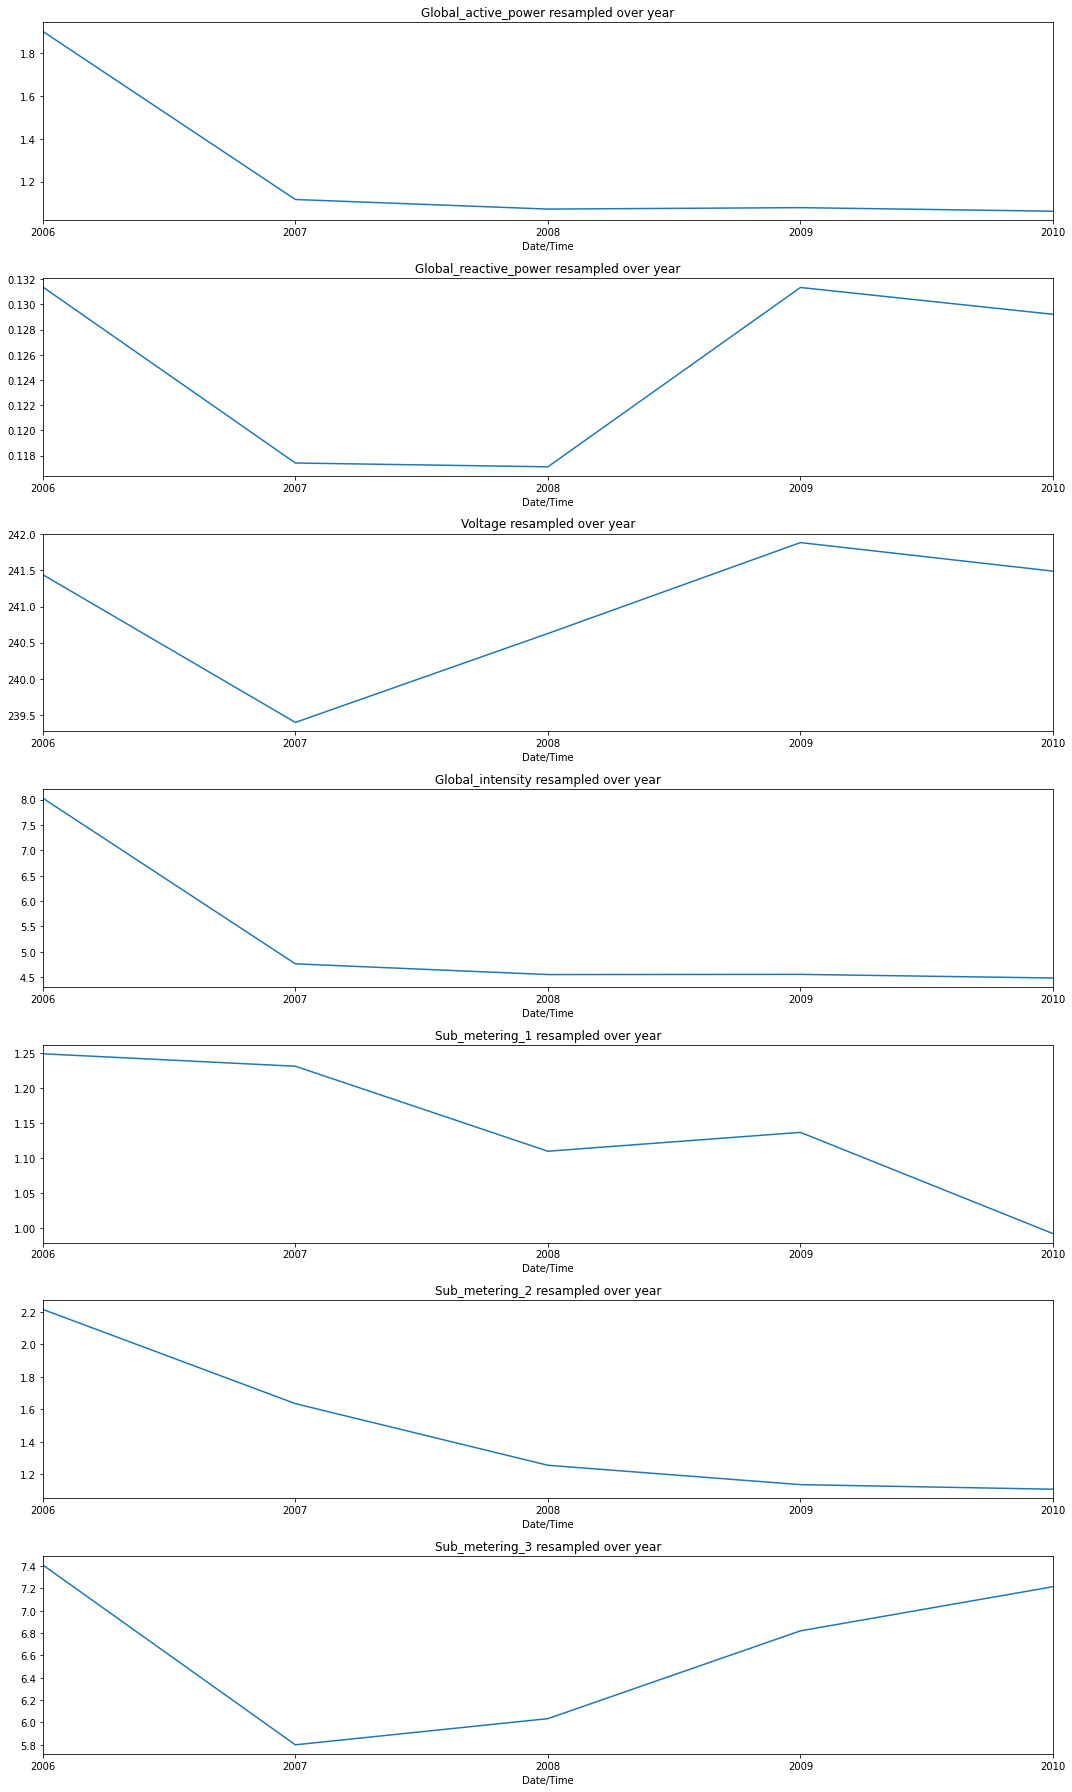

In [12]:
# Observing by resampling data for Year

i = 1
plt.figure(figsize = (15,25))
for feature in data.columns:
    plt.subplot(len(data.columns),1,i)
    data[feature].resample('A').mean().plot(title = '{} resampled over year'.format(feature))
    plt.xlabel('Date/Time')
    plt.tight_layout()
    i += 1

From the above graphs we can clearly observe the variation in the feature values when observed based on Day, Month and Year, thus we can try to identify the reason of the variations based on different factors like seasons, holidays, working hours, idle hours etc.

## Observing the correlation between features

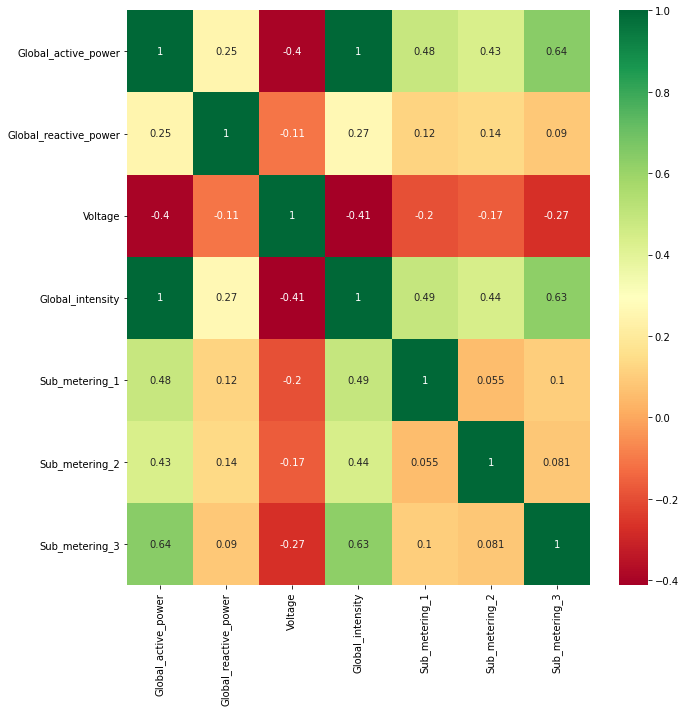

In [13]:
# plotting a Heatmap

corrmat = data.corr()
features = corrmat.index
plt.figure(figsize = [10,10])

g = sns.heatmap(data[features].corr(),annot = True, cmap = "RdYlGn")
plt.tight_layout()

Here it can be clearly seen that all the features have positive correlation with 'Global_active_power' except 'Voltage' that have a negative correlation.

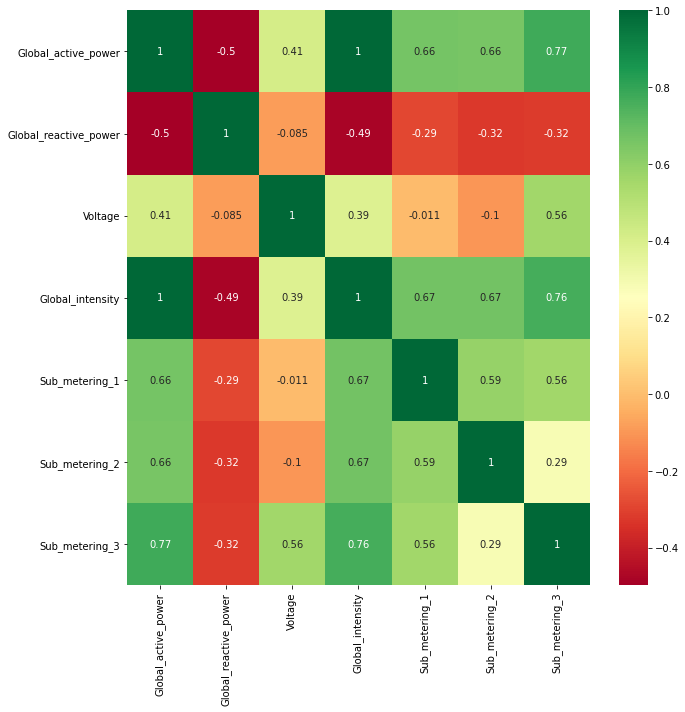

In [14]:
# plotting a Heatmap for resampled data by Month

corrmat = data.resample('M').mean().corr()
features = corrmat.index
plt.figure(figsize = [10,10])

g = sns.heatmap(data[features].resample('M').mean().corr(),annot = True, cmap = "RdYlGn")
plt.tight_layout()

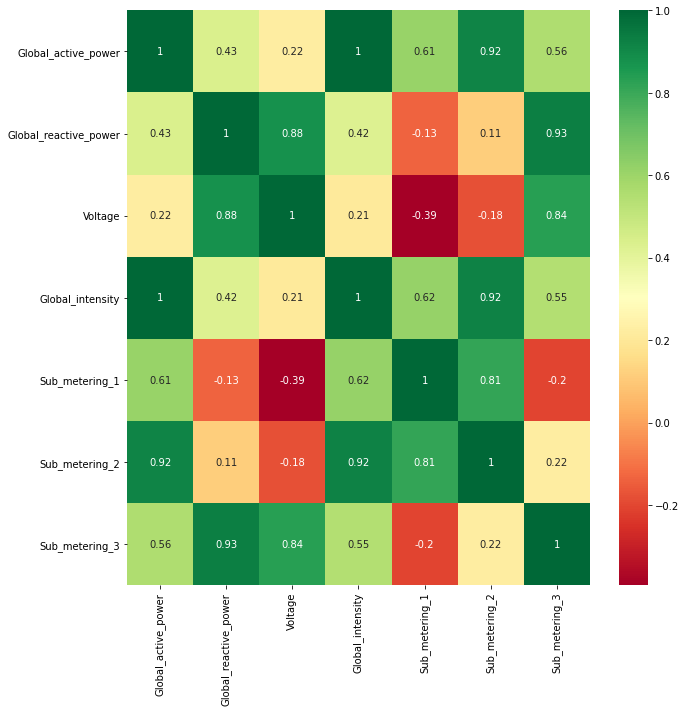

In [15]:
# plotting a Heatmap for resampled data by Year

corrmat = data.resample('A').mean().corr()
features = corrmat.index
plt.figure(figsize = [10,10])

g = sns.heatmap(data[features].resample('A').mean().corr(),annot = True, cmap = "RdYlGn")
plt.tight_layout()

We can observe that the correlation between features can be varied by resampling the data. For data resampled by Year, our dependent feature 'Global_active_power' is having good positive correlation with independent features.

In order to reduce the computation time for the model. We can resample the data over hour (the original data are given in minutes). This will reduce the size of data from 2075259 to 34589 but keep the overall strucure of data similar.

In [16]:
# resampling the data

data_resample = data.resample('h').mean()
data_resample

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667
...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000


## Scaling the features

In [17]:
# scaling the features in range [0,1]

scaler = MinMaxScaler()
data_scaled_arr = scaler.fit_transform(data_resample)
data_scaled_arr

array([[0.63681623, 0.29573827, 0.33794529, ..., 0.        , 0.01136636,
        0.78241815],
       [0.54504495, 0.10335773, 0.33550078, ..., 0.        , 0.14465183,
        0.78267595],
       [0.50900588, 0.11007318, 0.28380167, ..., 0.        , 0.03086863,
        0.7741686 ],
       ...,
       [0.2385342 , 0.07752906, 0.41839455, ..., 0.        , 0.00143575,
        0.        ],
       [0.16153105, 0.07899268, 0.52024552, ..., 0.        , 0.022972  ,
        0.        ],
       [0.12594772, 0.        , 0.53152393, ..., 0.        , 0.        ,
        0.        ]])

## Splitting the data in Train and Test datasets

In [18]:
# dependent and independent data split

x = data_scaled_arr[:,1:]
y = data_scaled_arr[:,0]

In [19]:
# train-test split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(24212, 6) (10377, 6) (24212,) (10377,)


In [20]:
# [samples, timesteps] into [samples, timesteps, features], reshaping input into the 3D format as expected by LSTM

x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(24212, 1, 6) (10377, 1, 6) (24212,) (10377,)


## Building the LSTM model

In [21]:
# creating the model

model = Sequential()

model.add(LSTM(70, activation = 'relu', return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fitting the model
history = model.fit(x_train, y_train, epochs=20, batch_size=70, validation_data=(x_test, y_test), verbose=2, shuffle=False)

Epoch 1/20
346/346 - 2s - loss: 0.0060 - val_loss: 1.7982e-04
Epoch 2/20
346/346 - 1s - loss: 4.9387e-04 - val_loss: 3.5199e-05
Epoch 3/20
346/346 - 1s - loss: 4.0764e-04 - val_loss: 3.0589e-05
Epoch 4/20
346/346 - 1s - loss: 3.9340e-04 - val_loss: 2.6971e-05
Epoch 5/20
346/346 - 1s - loss: 3.7237e-04 - val_loss: 3.7012e-05
Epoch 6/20
346/346 - 1s - loss: 3.6096e-04 - val_loss: 2.0703e-05
Epoch 7/20
346/346 - 1s - loss: 3.6307e-04 - val_loss: 3.8377e-05
Epoch 8/20
346/346 - 1s - loss: 3.3457e-04 - val_loss: 3.7369e-05
Epoch 9/20
346/346 - 1s - loss: 3.3569e-04 - val_loss: 2.4757e-05
Epoch 10/20
346/346 - 1s - loss: 3.2770e-04 - val_loss: 5.6341e-05
Epoch 11/20
346/346 - 1s - loss: 3.3578e-04 - val_loss: 4.4118e-05
Epoch 12/20
346/346 - 1s - loss: 3.3319e-04 - val_loss: 2.2413e-05
Epoch 13/20
346/346 - 1s - loss: 3.2345e-04 - val_loss: 4.3530e-05
Epoch 14/20
346/346 - 1s - loss: 3.2628e-04 - val_loss: 5.7283e-05
Epoch 15/20
346/346 - 1s - loss: 3.3145e-04 - val_loss: 2.4000e-05
Epoch 16

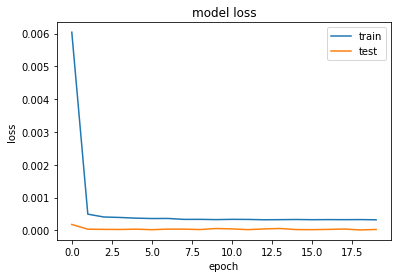

In [22]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [23]:
# making predictions

y_pred = model.predict(x_test)
y_pred

array([[0.09629259],
       [0.08879445],
       [0.08443388],
       ...,
       [0.04538399],
       [0.2099292 ],
       [0.12041971]], dtype=float32)

In [24]:
# calculate RMSE for predictions made

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.005


As we can see that the value of Root mean squared error is very low which means that our model is making good predictions.

## Making predictions

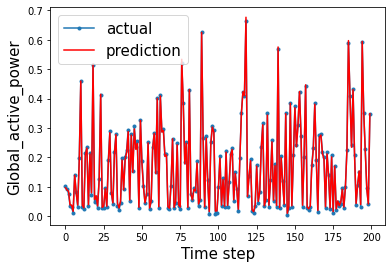

In [25]:
# now we will make predictions for next 200 hours

aa = [x for x in range(200)]
plt.plot(aa, y_test[:200], marker='.', label="actual")
plt.plot(aa, y_pred[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In the above graph we can see that the predicted values are nearly similar to the actual values which shows that our model is performing really well.